In [46]:
import os 
import sys

running_path = "/Odyssey/private/o23gauvr/code/FASCINATION/"
os.chdir(running_path)
#sys.path.insert(0,running_path)

In [47]:


import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_ckpt_path 
from src.select_outputs_on_params import select_outputs_on_params
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import re
from src.utils import *
from scipy.ndimage import convolve
from scipy.signal import medfilt
import copy




In [48]:
plt.style.use('ggplot')

In [49]:
cmap = plt.get_cmap('viridis')

In [50]:
gpu = 0
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [51]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Not reloading datamodule


In [52]:
save_fig = False

In [53]:
load_pca = True

In [54]:
norm = False

In [55]:
with open(f"pickle/rmse_ssp_pca_on_dm_3D_norm_False.pkl", "rb") as file:
    old_pca_rmse_dict = pickle.load(file)  

In [56]:
if load_pca:
    with open(f"/Odyssey/private/o23gauvr/code/FASCINATION/pickle/rmse_pca_all_components_with_pooling_upsampling_unorm_sklearn_pca.pkl", "rb") as file:
        pca_rmse_dict = pickle.load(file)  
        
else:
    pca_rmse_dict = {}
    

In [57]:
pca_n_layers = 4 #Number of layers to keep for the PCA


# Functions

In [58]:
def get_min_max_idx(arr,axs=1, pad=True):
    grad = np.diff(arr,axis=axs)
    grad_sign = np.sign(grad)
    min_max = np.diff(grad_sign,axis=axs) 
    min_max = np.abs(np.sign(min_max))
    if pad:
        min_max = np.pad(min_max, ((0,0),(1,1),(0,0),(0,0)), 'constant', constant_values=1)
    return min_max


In [59]:
def calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_pca, as_ratio=False):
    # Define the kernel
    kernel = np.ones((1, 7, 1, 1))  # Shape: [D1, D2, D3]

    # Expand the truth array with the kernel
    truth_expanded = convolve(min_max_idx_truth, kernel, mode='constant', cval=0.0)
    pca_expanded = convolve(min_max_idx_pca, kernel, mode='constant', cval=0.0)


    # Compute the true positives
    true_positives = (truth_expanded > 0) & (min_max_idx_pca > 0)
    num_true_positives = np.sum(true_positives)

    # Compute the false positives
    false_positives = (truth_expanded == 0) & (min_max_idx_pca > 0)
    num_false_positives = np.sum(false_positives)

    # Compute the true negatives
    true_negatives = (min_max_idx_truth == 0) & (min_max_idx_pca == 0)
    num_true_negatives = np.sum(true_negatives)

    # Compute the false negatives
    false_negatives = (min_max_idx_truth > 0) & (pca_expanded == 0)
    num_false_negatives = np.sum(false_negatives)

    # Create the confusion matrix
    confusion_matrix = np.array([[num_true_negatives, num_false_positives],
                                 [num_false_negatives, num_true_positives]])

    if as_ratio:
        total = np.sum(confusion_matrix)
        confusion_matrix = confusion_matrix / total

    
    precision_score = num_true_positives / (num_true_positives + num_false_positives)
    recall_score = num_true_positives / (num_true_positives + num_false_negatives)
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return confusion_matrix, f1_score

# RMSE

In [60]:

ckpt_dict = {}

base_dir = "/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation"


# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)


{'AE_dense_3_pool': '/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation/AE_dense_3_pool', 'AE_dense_0_pool': '/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation/AE_dense_0_pool', 'AE_dense_1_pool': '/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation/AE_dense_1_pool', 'AE_dense_2_pool': '/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation/AE_dense_2_pool'}


In [61]:
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))
    print(f"Model {model_carac} with {len(ckpt_list)} checkpoints")

Model AE_dense_3_pool with 11 checkpoints
Model AE_dense_0_pool with 8 checkpoints
Model AE_dense_1_pool with 8 checkpoints
Model AE_dense_2_pool with 8 checkpoints


In [63]:


verbose = True
filtering = True
kernel = 5

ae_rmse_dict = {"SSP":{},
                "ECS":{},
                "mean_error_n_min_max":{},
                "conf_matrix":{},
                "F1_score":{}}

if filtering:
    filtered_ae_rmse_dict = copy.deepcopy(ae_rmse_dict)

        
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))


    for ckpt_path in tqdm(ckpt_list):
        ckpt_path = str(ckpt_path)
        
        model_name = " ".join((ckpt_path.split("AE")[-1]).split("/")).replace("_", "  ")
        print(f"\n{model_name}")
        

        if model_carac not in ae_rmse_dict["SSP"].keys():
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac] = {}

            if filtering:
                for sub_dic in filtered_ae_rmse_dict.values():
                    sub_dic[model_carac] = {}
        
        
        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        
    
        except:
            print(f"Can't load config")
            continue
        
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_ssp_arr, _ = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)

        
        else:
            if verbose:
                print("Inititing datamodule; Generating train and test datasets")
            
            
            dm = hydra.utils.call(cfg.datamodule)  
            test_ssp_arr, dm = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm
            


        input_test_shape = test_ssp_tens.shape
        depth_array = dm.depth_array


        
        if verbose:
            print("Loading model, generating AE output")      
        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    
        except:
            print(f"Can't load model")
            continue

        ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy().astype(test_ssp_arr.dtype)  ##operation is too long on CPU


        try:
            bottleneck_shape = lit_model.model_AE.bottleneck_shape
        except:
            bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape
            
        compression_rate_ae = test_ssp_tens.numel()/bottleneck_shape.numel()

        if bottleneck_shape in ae_rmse_dict["SSP"][model_carac].keys():
            continue

        
        if not norm:
            test_ssp_arr = unorm_ssp_arr_3D(test_ssp_arr, dm)
            ssp_ae_test_arr = unorm_ssp_arr_3D(ssp_ae_test_arr, dm)
            


        max_ssp_truth_idx = np.nanargmax(test_ssp_arr, axis=1)
        ecs_truth = depth_array[max_ssp_truth_idx]

        max_ssp_ae_idx = np.nanargmax(ssp_ae_test_arr, axis=1)
        ecs_pred_ae = depth_array[max_ssp_ae_idx]
            
            
        ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr)**2))
        ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))


        min_max_idx_truth = get_min_max_idx(test_ssp_arr, pad=False)
        min_max_idx_ae = get_min_max_idx(ssp_ae_test_arr, pad=False)
        mean_error_n_min_max = np.mean(np.abs(np.sum(min_max_idx_truth, axis=1)-np.sum(min_max_idx_ae, axis=1)))

        conf_matrix_counts, F1_score = calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, as_ratio=False)
        
        

        #mean_error_ssp_min_max = np.sqrt(np.mean(min_max_idx_truth*(test_ssp_arr-ssp_ae_test_arr)**2))



        
        ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
        ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
        ae_rmse_dict["mean_error_n_min_max"][model_carac][bottleneck_shape] = mean_error_n_min_max
        ae_rmse_dict["conf_matrix"][model_carac][bottleneck_shape] = conf_matrix_counts
        ae_rmse_dict["F1_score"][model_carac][bottleneck_shape] = F1_score
        #ae_rmse_dict["ssp_min_max"][model_carac][bottleneck_shape] = mean_error_ssp_min_max


        if filtering:

            filtered_ae_test_arr = medfilt(ssp_ae_test_arr, kernel_size=(1,kernel,1,1))
            
            max_ssp_ae_idx = np.nanargmax(filtered_ae_test_arr, axis=1)
            ecs_pred_ae = depth_array[max_ssp_ae_idx]
            ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - filtered_ae_test_arr)**2))
            ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))
            min_max_idx_ae = get_min_max_idx(filtered_ae_test_arr, pad=False)
            mean_error_n_min_max = np.mean(np.abs(np.sum(min_max_idx_truth, axis=1)-np.sum(min_max_idx_ae, axis=1)))

            conf_matrix_counts, F1_score = calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, as_ratio=False)

            filtered_ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
            filtered_ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
            filtered_ae_rmse_dict["mean_error_n_min_max"][model_carac][bottleneck_shape] = mean_error_n_min_max
            filtered_ae_rmse_dict["conf_matrix"][model_carac][bottleneck_shape] = conf_matrix_counts
            filtered_ae_rmse_dict["F1_score"][model_carac][bottleneck_shape] = F1_score

        if verbose:
            print("bottleneck: ", bottleneck_shape)
            print("cr: ",compression_rate_ae)
     
        



  0%|          | 0/11 [00:00<?, ?it/s]


  dense  3  pool channels  [107, 100, 100, 100] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  18-05 checkpoints val  loss=0.03-epoch=144.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
  9%|▉         | 1/11 [00:30<05:03, 30.30s/it]

bottleneck:  torch.Size([37, 100, 22, 30, 1])
cr:  67.70181818181818

  dense  3  pool channels  [107, 100, 50, 107] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  07-55 checkpoints val  loss=0.03-epoch=142.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 18%|█▊        | 2/11 [01:00<04:33, 30.38s/it]

bottleneck:  torch.Size([37, 107, 22, 30, 1])
cr:  63.27272727272727

  dense  3  pool channels  [107, 100, 50, 10] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  17-58 checkpoints val  loss=0.03-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 27%|██▋       | 3/11 [01:31<04:03, 30.40s/it]

bottleneck:  torch.Size([37, 10, 22, 30, 1])
cr:  677.0181818181818

  dense  3  pool channels  [107, 100, 50, 1] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  04-03 checkpoints val  loss=0.53-epoch=148.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 36%|███▋      | 4/11 [02:01<03:32, 30.29s/it]

bottleneck:  torch.Size([37, 1, 22, 30, 1])
cr:  6770.181818181818

  dense  3  pool channels  [107, 100, 50, 2] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  21-44 checkpoints val  loss=0.53-epoch=148.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 45%|████▌     | 5/11 [02:31<03:01, 30.30s/it]

bottleneck:  torch.Size([37, 2, 22, 30, 1])
cr:  3385.090909090909

  dense  3  pool channels  [107, 100, 50, 30] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  14-17 checkpoints val  loss=0.03-epoch=144.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 55%|█████▍    | 6/11 [03:02<02:31, 30.38s/it]

bottleneck:  torch.Size([37, 30, 22, 30, 1])
cr:  225.6727272727273

  dense  3  pool channels  [107, 100, 50, 50] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  11-04 checkpoints val  loss=0.03-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 64%|██████▎   | 7/11 [03:32<02:01, 30.40s/it]

bottleneck:  torch.Size([37, 50, 22, 30, 1])
cr:  135.40363636363637

  dense  3  pool channels  [107, 100, 50, 5] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  07-27 checkpoints val  loss=0.03-epoch=144.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 73%|███████▎  | 8/11 [04:02<01:30, 30.29s/it]

bottleneck:  torch.Size([37, 5, 22, 30, 1])
cr:  1354.0363636363636

  dense  3  pool channels  [107, 100, 50, 70] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  04-10 checkpoints val  loss=0.03-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 82%|████████▏ | 9/11 [04:33<01:00, 30.34s/it]

bottleneck:  torch.Size([37, 70, 22, 30, 1])
cr:  96.71688311688311

  dense  3  pool channels  [107, 100, 80, 70] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  21-57 checkpoints val  loss=0.03-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 91%|█████████ | 10/11 [04:33<00:21, 21.19s/it]


  dense  3  pool channels  [107, 107, 107, 107] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  14-17 checkpoints val  loss=0.03-epoch=144.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
  0%|          | 0/8 [00:00<?, ?it/s]


  dense  0  pool channels  [107, 100, 100, 100] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  18-29 checkpoints val  loss=0.01-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 12%|█▎        | 1/8 [00:29<03:29, 29.94s/it]

bottleneck:  torch.Size([37, 100, 174, 240, 1])
cr:  1.07

  dense  0  pool channels  [107, 100, 50, 100] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  00-20 checkpoints val  loss=0.01-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 25%|██▌       | 2/8 [00:30<01:16, 12.73s/it]


  dense  0  pool channels  [107, 100, 50, 10] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  00-20 checkpoints val  loss=0.01-epoch=137.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 38%|███▊      | 3/8 [01:01<01:44, 20.80s/it]

bottleneck:  torch.Size([37, 10, 174, 240, 1])
cr:  10.7

  dense  0  pool channels  [107, 100, 50, 10] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  18-31 checkpoints val  loss=0.01-epoch=137.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 50%|█████     | 4/8 [01:01<00:51, 12.86s/it]


  dense  0  pool channels  [107, 100, 50, 2] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  22-26 checkpoints val  loss=0.53-epoch=149.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 62%|██████▎   | 5/8 [01:31<00:57, 19.05s/it]

bottleneck:  torch.Size([37, 2, 174, 240, 1])
cr:  53.5

  dense  0  pool channels  [107, 100, 50, 30] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  14-40 checkpoints val  loss=0.01-epoch=136.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 75%|███████▌  | 6/8 [02:02<00:45, 22.95s/it]

bottleneck:  torch.Size([37, 30, 174, 240, 1])
cr:  3.566666666666667

  dense  0  pool channels  [107, 100, 80, 70] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  22-23 checkpoints val  loss=0.01-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 88%|████████▊ | 7/8 [02:32<00:25, 25.39s/it]

bottleneck:  torch.Size([37, 70, 174, 240, 1])
cr:  1.5285714285714285

  dense  0  pool channels  [107, 107, 107, 107] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  14-40 checkpoints val  loss=0.01-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 8/8 [03:03<00:00, 22.88s/it]


bottleneck:  torch.Size([37, 107, 174, 240, 1])
cr:  1.0


  0%|          | 0/8 [00:00<?, ?it/s]


  dense  1  pool channels  [107, 2] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  07-03 checkpoints val  loss=0.08-epoch=149.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 12%|█▎        | 1/8 [00:30<03:34, 30.62s/it]

bottleneck:  torch.Size([37, 2, 87, 120, 1])
cr:  214.0

  dense  1  pool channels  [107, 3] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  03-35 checkpoints val  loss=0.08-epoch=146.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 25%|██▌       | 2/8 [01:01<03:03, 30.64s/it]

bottleneck:  torch.Size([37, 3, 87, 120, 1])
cr:  142.66666666666666

  dense  1  pool channels  [107, 5] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  00-02 checkpoints val  loss=0.01-epoch=136.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 38%|███▊      | 3/8 [01:31<02:32, 30.55s/it]

bottleneck:  torch.Size([37, 5, 87, 120, 1])
cr:  85.6

  dense  1  pool channels  [107, 10] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  10-45 checkpoints val  loss=0.01-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 50%|█████     | 4/8 [02:02<02:01, 30.50s/it]

bottleneck:  torch.Size([37, 10, 87, 120, 1])
cr:  42.8

  dense  1  pool channels  [107, 30] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  07-11 checkpoints val  loss=0.01-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 62%|██████▎   | 5/8 [02:32<01:31, 30.49s/it]

bottleneck:  torch.Size([37, 30, 87, 120, 1])
cr:  14.266666666666667

  dense  1  pool channels  [107, 50] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  03-37 checkpoints val  loss=0.00-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 75%|███████▌  | 6/8 [03:02<01:00, 30.38s/it]

bottleneck:  torch.Size([37, 50, 87, 120, 1])
cr:  8.56

  dense  1  pool channels  [107, 107] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  00-03 checkpoints val  loss=0.00-epoch=146.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 88%|████████▊ | 7/8 [03:33<00:30, 30.42s/it]

bottleneck:  torch.Size([37, 107, 87, 120, 1])
cr:  4.0

  dense  1  pool channels  [107, 1] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  10-33 checkpoints val  loss=0.09-epoch=149.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 8/8 [04:03<00:00, 30.43s/it]


bottleneck:  torch.Size([37, 1, 87, 120, 1])
cr:  428.0


  0%|          | 0/8 [00:00<?, ?it/s]


  dense  2  pool channels  [107, 50, 2] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  07-11 checkpoints val  loss=0.53-epoch=148.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 12%|█▎        | 1/8 [00:30<03:32, 30.39s/it]

bottleneck:  torch.Size([37, 2, 44, 60, 1])
cr:  846.2727272727273

  dense  2  pool channels  [107, 50, 3] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  03-47 checkpoints val  loss=0.53-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 25%|██▌       | 2/8 [01:00<03:02, 30.50s/it]

bottleneck:  torch.Size([37, 3, 44, 60, 1])
cr:  564.1818181818181

  dense  2  pool channels  [107, 50, 5] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  00-06 checkpoints val  loss=0.01-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 38%|███▊      | 3/8 [01:32<02:35, 31.03s/it]

bottleneck:  torch.Size([37, 5, 44, 60, 1])
cr:  338.5090909090909

  dense  2  pool channels  [107, 50, 10] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  10-55 checkpoints val  loss=0.01-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 50%|█████     | 4/8 [02:02<02:03, 30.76s/it]

bottleneck:  torch.Size([37, 10, 44, 60, 1])
cr:  169.25454545454545

  dense  2  pool channels  [107, 60, 30] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  07-18 checkpoints val  loss=0.01-epoch=143.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 62%|██████▎   | 5/8 [02:33<01:31, 30.64s/it]

bottleneck:  torch.Size([37, 30, 44, 60, 1])
cr:  56.41818181818182

  dense  2  pool channels  [107, 100, 50] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  03-42 checkpoints val  loss=0.01-epoch=144.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 75%|███████▌  | 6/8 [03:03<01:01, 30.57s/it]

bottleneck:  torch.Size([37, 50, 44, 60, 1])
cr:  33.85090909090909

  dense  2  pool channels  [107, 107, 107] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  00-05 checkpoints val  loss=0.01-epoch=145.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
 88%|████████▊ | 7/8 [03:34<00:30, 30.53s/it]

bottleneck:  torch.Size([37, 107, 44, 60, 1])
cr:  15.818181818181818

  dense  2  pool channels  [107, 50, 1] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-27  10-34 checkpoints val  loss=0.53-epoch=148.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 8/8 [04:04<00:00, 30.60s/it]

bottleneck:  torch.Size([37, 1, 44, 60, 1])
cr:  1692.5454545454545


In [64]:
ae_rmse_dict

{'SSP': {'AE_dense_3_pool': {torch.Size([37, 100, 22, 30, 1]): 1.8377151,
   torch.Size([37, 107, 22, 30, 1]): 1.8432229,
   torch.Size([37, 10, 22, 30, 1]): 1.8695543,
   torch.Size([37, 1, 22, 30, 1]): 9.147312,
   torch.Size([37, 2, 22, 30, 1]): 9.147312,
   torch.Size([37, 30, 22, 30, 1]): 1.8671086,
   torch.Size([37, 50, 22, 30, 1]): 1.8700941,
   torch.Size([37, 5, 22, 30, 1]): 1.8926107,
   torch.Size([37, 70, 22, 30, 1]): 1.8492308},
  'AE_dense_0_pool': {torch.Size([37, 100, 174, 240, 1]): 0.54038745,
   torch.Size([37, 10, 174, 240, 1]): 0.543742,
   torch.Size([37, 2, 174, 240, 1]): 9.147303,
   torch.Size([37, 30, 174, 240, 1]): 0.52474207,
   torch.Size([37, 70, 174, 240, 1]): 0.52747536,
   torch.Size([37, 107, 174, 240, 1]): 0.53965753},
  'AE_dense_1_pool': {torch.Size([37, 2, 87, 120, 1]): 3.1498327,
   torch.Size([37, 3, 87, 120, 1]): 3.0703025,
   torch.Size([37, 5, 87, 120, 1]): 0.6608227,
   torch.Size([37, 10, 87, 120, 1]): 0.55011785,
   torch.Size([37, 30, 87, 

In [65]:


# plt.plot(test_ssp_arr[10,:,10,10],dm.depth_array)
# plt.plot(ssp_ae_test_arr[10,:,10,10],dm.depth_array)

# plt.gca().invert_yaxis()
# x_min, x_max = plt.gca().get_xlim()
# non_zero_indices_truth = min_max_idx_truth[10,:,10,10] != 0
# non_zero_indices_ae = min_max_idx_ae[10,:,10,10] != 0

# plt.hlines(min_max_idx_truth[10,:,10,10][non_zero_indices_truth] * dm.depth_array[non_zero_indices_truth], x_min, x_max, colors="r")

# plt.hlines(min_max_idx_ae[10,:,10,10][non_zero_indices_ae] * dm.depth_array[non_zero_indices_ae], x_min, x_max, colors="b")



In [66]:
# if not load_pca:
#     train_ssp_arr, _, _, _, _ = loading_datamodule_phase(dm, phase = "fit")
#     input_train_shape = train_ssp_arr.shape

# if bottleneck_shape[2] != n_components and not load_pca:


#     n_components = bottleneck_shape[2]
#     compression_rate_pca = 107/n_components

#     if verbose:
#         print("training PCA, generating PCA output")    
        
#     pca = PCA(n_components = n_components, svd_solver = 'auto')
#     #pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107)) 

#     if norm:
#         ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(train_ssp_arr.transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)
    
#     else :
#         ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(unorm_ssp_arr_3D(train_ssp_arr).transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)

#     if ecs_algo == "first_max":
#         ecs_pred_pca = explicit_ecs_3D(torch.tensor(ssp_pca_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
    
#     elif ecs_algo == "max":
#         max_ssp_pca_idx = np.nanargmax(ssp_pca_test_arr, axis=1)
#         ecs_pred_pca = depth_array[max_ssp_pca_idx]
        

#     pca_ssp_rmse_dict[n_components] = np.sqrt(np.mean((test_ssp_arr - ssp_pca_test_arr)**2))
    
#     pca_ecs_rmse_dict[n_components]  = np.sqrt(np.mean((ecs_truth - ecs_pred_pca)**2))
    

## add specific model

In [67]:
if dm_dict == {}:
    cfg_path = "config/xp/autoencoder_V2.yaml"
    cfg = OmegaConf.load(cfg_path)
    display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

    dm = hydra.utils.instantiate(cfg.datamodule)
    #_, test_ssp_tens, dm = loading_datamodule_phase(dm, phase = "test")
    dm.setup("test")


    ae_rmse_dict = {"SSP":{},
                    "ECS":{},
                    "mean_error_n_min_max":{},
                    "conf_matrix":{},
                    "F1_score":{}}


In [68]:

# ae_rmse_dict = {"SSP":{},
#                 "ECS":{}}

# pickle_data_path_list = ["pickle/pooling_upsampling_pca_pre_treatment_rmse_norm_False.pkl"]
# pca_key = [30, 50, 100, 107]
# new_data = {}
# for data_path in pickle_data_path_list:
#     with open(data_path, "rb") as file:
#         new_data = pickle.load(file)

# for key in list(new_data["SSP"].keys()):
#     if any(key.endswith(f"_{num}") for num in pca_key):
#         ae_rmse_dict["SSP"][key] = new_data["SSP"][key]
#         ae_rmse_dict["ECS"][key] = new_data["ECS"][key]


# Plot

In [69]:
components_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    sorted_components = [key[2] if len(key)==5 else key[1] for key in sorted_keys]
    components_sorted_ae_rmse_dict["SSP"][model] = (sorted_components, [ae_rmse_dict["SSP"][model][key] for key in sorted_keys])
    components_sorted_ae_rmse_dict["ECS"][model] = (sorted_components, [ae_rmse_dict["ECS"][model][key] for key in sorted_keys])


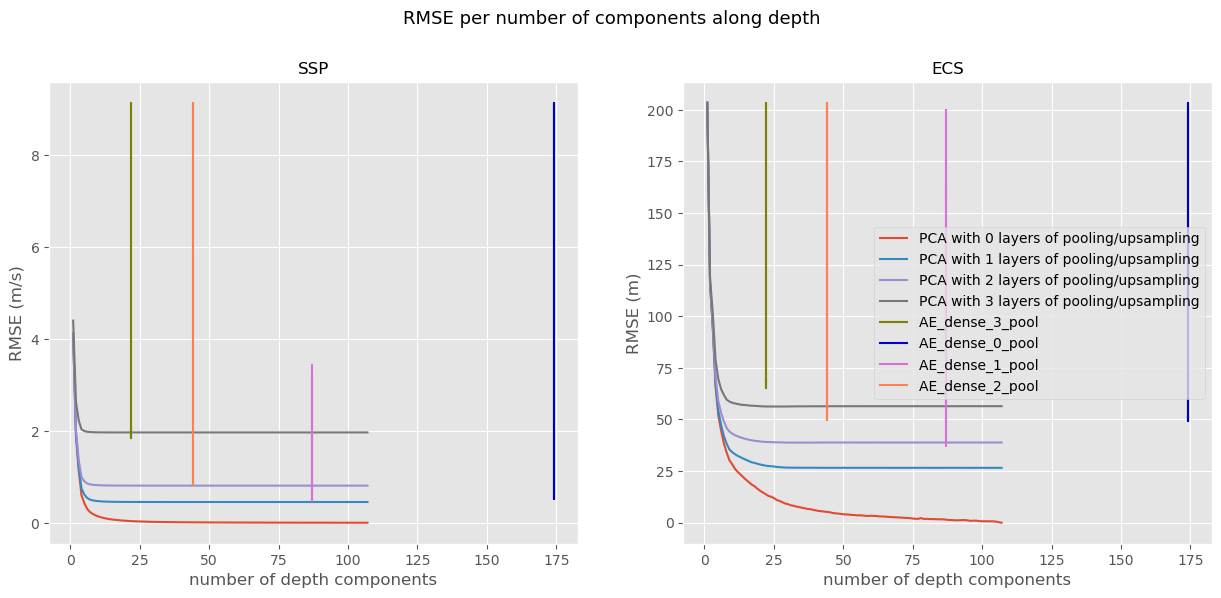

In [70]:

colors = ['olive', 'mediumblue', 'orchid', 'coral',
          'tomato','lightskyblue', 'mediumseagreen',
          'orange','yellowgreen', 'deepskyblue', 'navy', 
          'gold', 'dodgerblue', 'royalblue', 
          ]

fig,axs = plt.subplots(1,2,figsize=(15,6))



for n in range(pca_n_layers):

    if pca_n_layers == 1:
        label = "PCA"
    else:
        label = f"PCA with {n} layers of pooling/upsampling"

    axs[0].plot(pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), label = label)
    axs[1].plot(pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), label = label)

i = 0

for model in components_sorted_ae_rmse_dict["SSP"].keys():
        
    
    if len(components_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(components_sorted_ae_rmse_dict["SSP"][model][0], components_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(components_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(components_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, explicit model")  # s adjusts the cross size
        axs[1].hlines(components_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(components_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i = i+1     
        
    

        
    
    else:

        axs[0].plot(components_sorted_ae_rmse_dict["SSP"][model][0],components_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model} ")

        i=i+1
        



if norm:
    axs[0].set_ylabel("RMSE (normalized)")  
else:    
    axs[0].set_ylabel("RMSE (m/s)")  

axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper right", prop={'size': 8})    
    
if norm: 
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
else:   
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 8
elif len(labels) > 5:
    legend_fontsize = 10
else:
    legend_fontsize = 13

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:
    ax.set_xlabel("number of depth components")
    


    
fig_title = f"RMSE per number of components along depth"
fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [71]:
pca_cr_dict = {}
for model in pca_rmse_dict["lat_lon_shape"].keys():
    reduced_lat,reduced_lon = pca_rmse_dict["lat_lon_shape"][model][-2:]
    spatial_cr = dm.test_shape[2]*dm.test_shape[3]/(reduced_lat*reduced_lon)
    pca_cr_dict[model] = [spatial_cr*dm.test_shape[1]/n for n in range(1,dm.test_shape[1]+1)] 


In [72]:
filtered_ae_rmse_dict["F1_score"]["AE_dense_0_pool"]

{torch.Size([37, 100, 174, 240, 1]): 0.612729529514696,
 torch.Size([37, 10, 174, 240, 1]): 0.5579420899719513,
 torch.Size([37, 2, 174, 240, 1]): 0.22516430833385537,
 torch.Size([37, 30, 174, 240, 1]): 0.5856369411068143,
 torch.Size([37, 70, 174, 240, 1]): 0.623099995318964,
 torch.Size([37, 107, 174, 240, 1]): 0.6224092835608296}

In [73]:
ae_rmse_dict["F1_score"]["AE_dense_0_pool"]

{torch.Size([37, 100, 174, 240, 1]): 0.5364284770750767,
 torch.Size([37, 10, 174, 240, 1]): 0.44391275044436546,
 torch.Size([37, 2, 174, 240, 1]): 0.15797273189986166,
 torch.Size([37, 30, 174, 240, 1]): 0.4978677685351597,
 torch.Size([37, 70, 174, 240, 1]): 0.5009049961562994,
 torch.Size([37, 107, 174, 240, 1]): 0.5273975280893995}

In [74]:

cr_sorted_ae_rmse_dict = {"SSP":{},
                          "ECS":{},
                          "mean_error_n_min_max":{},
                          "F1_score":{}}

for model in ae_rmse_dict["SSP"].keys():
    
    cr_key_dict = {np.prod(dm.test_shape)/key.numel(): key for key in ae_rmse_dict["SSP"][model].keys()}
    sorted_cr_key = sorted(cr_key_dict.keys())
    
    # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    # sorted_components = [key[2] for key in sorted_keys]
    cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model] = (sorted_cr_key, [ae_rmse_dict["mean_error_n_min_max"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["F1_score"][model] = (sorted_cr_key, [ae_rmse_dict["F1_score"][model][cr_key_dict[key]] for key in sorted_cr_key])
     

if filtering:

    
    filtered_cr_sorted_ae_rmse_dict = {"SSP":{},
                                       "ECS":{},
                                       "mean_error_n_min_max":{},
                                       "F1_score":{}}

    for model in filtered_ae_rmse_dict["SSP"].keys():
        
        cr_key_dict = {np.prod(dm.test_shape)/key.numel(): key for key in filtered_ae_rmse_dict["SSP"][model].keys()}
        sorted_cr_key = sorted(cr_key_dict.keys())
        
        # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
        # sorted_components = [key[2] for key in sorted_keys]
        filtered_cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
        filtered_cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
        filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["mean_error_n_min_max"][model][cr_key_dict[key]] for key in sorted_cr_key])
        filtered_cr_sorted_ae_rmse_dict["F1_score"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["F1_score"][model][cr_key_dict[key]] for key in sorted_cr_key])

0
1
2
3


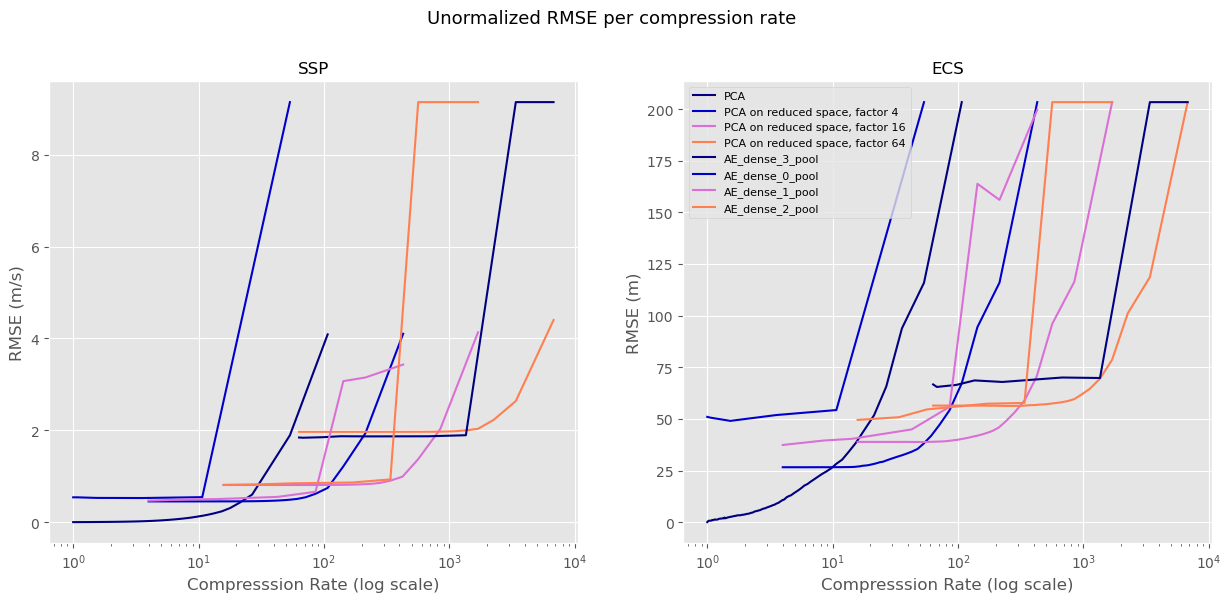

In [75]:
ecs_max = False

colors = ['navy', 'mediumblue', 'orchid', 'coral',
            'olive', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,axs = plt.subplots(1,2,figsize=(15,6))

i=0

for n in range(pca_n_layers):
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0


for model in cr_sorted_ae_rmse_dict["SSP"].keys():
    
    print(i)
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            


    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model}")

        i=i+1
        
        
        if ecs_max:
            axs[1].plot(cr_sorted_ae_rmse_dict["ECS max"][model][0], cr_sorted_ae_rmse_dict["ECS max"][model][1], c = colors[i], label = f"{model} max algo")

            i=i+1
            

                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    


if norm: 
    axs[0].set_ylabel("RMSE")  
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Normalized RMSE per compression rate"
    
else:   
    axs[0].set_ylabel("RMSE (m/s)")  
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Unormalized RMSE per compression rate"


    # Adjust the legend size based on the number of labels
    handles, labels = axs[1].get_legend_handles_labels()
    if len(labels) > 10:
        legend_fontsize = 7
    elif len(labels) > 5:
        legend_fontsize = 8
    else:
        legend_fontsize = 10

    axs[1].legend(prop={'size': legend_fontsize})
            
for ax in axs:

    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

# PCA versus dense 

select PCA layer 

In [76]:
pca_layer = [0,1,2,3]

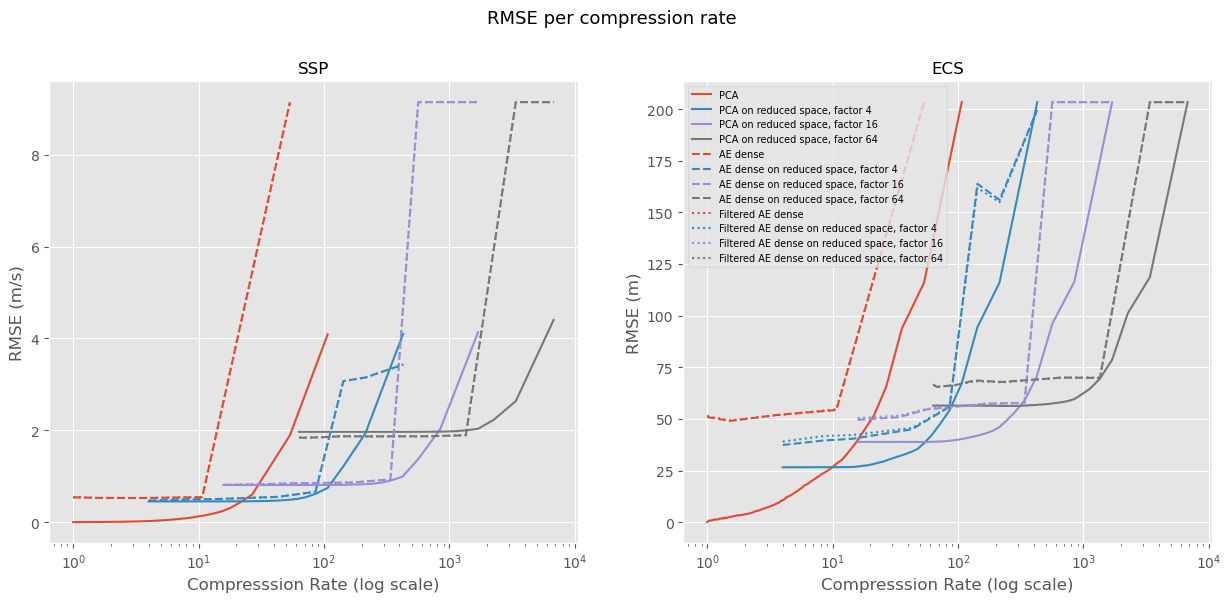

In [77]:
ecs_max = False

# colors = ['navy', 'orchid', 'coral',
#           'tomato','olive', 'mediumseagreen',
#           'mediumblue','yellowgreen', 'deepskyblue',
#             'orange', 'dodgerblue', 'royalblue' ]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig,axs = plt.subplots(1,2,figsize=(15,6))

i=0

for n in pca_layer:
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0

layer_cr_sorted_ae_rmse_dict = sorted(cr_sorted_ae_rmse_dict["SSP"].keys())


for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
    if n == 0:
        label = "AE dense"
    else:
        label = f"AE dense on reduced space, factor {4**n}"
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        

    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], ls='--', label = label)
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i],ls='--', label = label)

        i=i+1
        

i=0


if filtering:

    for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
        if n == 0:
            label = "Filtered AE dense"
        else:
            label = f"Filtered AE dense on reduced space, factor {4**n}"
        
        
        if len(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
            
            axs[0].scatter(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0], filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[0].hlines(filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[1].hlines(filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
            axs[1].vlines(filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
            
            i=i+1    
            

        
        else:

            axs[0].plot(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0],filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], ls=':', label = label)
            
            axs[1].plot(filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i],ls=':', label = label)

            i=i+1


                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    



axs[0].set_ylabel("RMSE (m/s)")  
axs[1].set_ylabel("RMSE (m)")  
axs[1].set_title("ECS",fontsize = 12)  
fig_title = f"RMSE per compression rate"


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 7
elif len(labels) > 5:
    legend_fontsize = 8
else:
    legend_fontsize = 10

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:

    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

# Min max detection

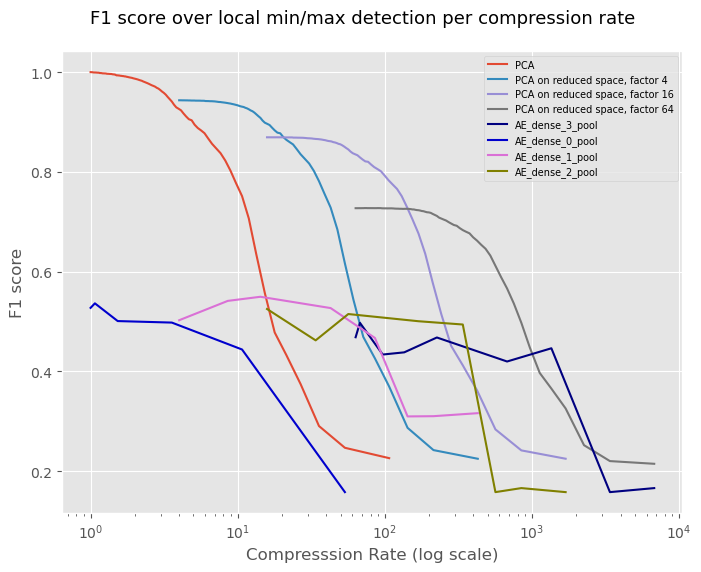

In [78]:
ecs_max = False
filtering = False

colors = ['navy', 'mediumblue', 'orchid', 'olive',
            'coral', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,ax = plt.subplots(1,1,figsize=(8,6))


for n in range(pca_n_layers):
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    ax.plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["F1_score"][f"Pool_upsample_{n}_layers"].values(), label = label)

i=0

for model in cr_sorted_ae_rmse_dict["SSP"].keys():
        
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        
        ax.scatter(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        ax.hlines(cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
        ax.vlines(cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')        

        i=i+1    
        
            


    
    else:

        ax.plot(cr_sorted_ae_rmse_dict["F1_score"][model][0],cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i], label = f"{model}")
        
        i=i+1
        
        
            

                




#axs[0].legend(loc = "upper left", prop={'size': 8})    



ax.set_ylabel("F1 score")  
fig_title = f"F1 score over local min/max detection per compression rate"
    


    # Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 7
elif len(labels) > 5:
    legend_fontsize = 8
else:
    legend_fontsize = 10

ax.legend(prop={'size': legend_fontsize})
            


ax.set_xlabel("Compresssion Rate (log scale)")
ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 0.95)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

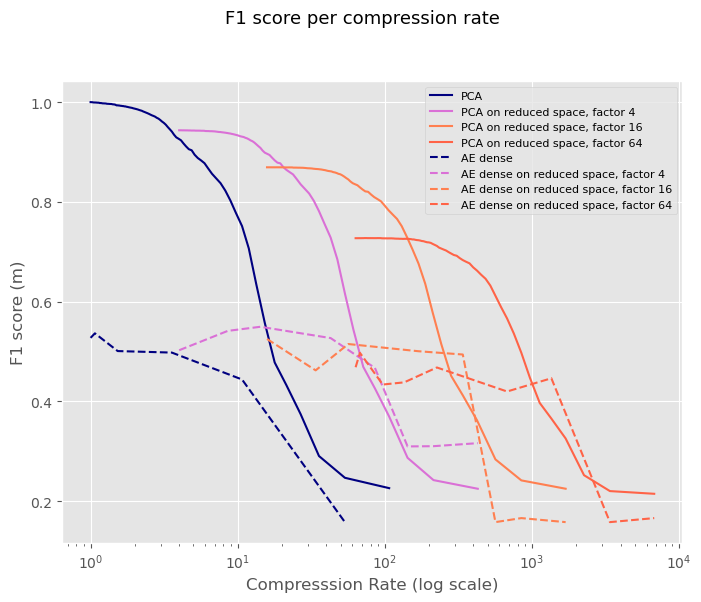

In [80]:
ecs_max = False

colors = ['navy', 'orchid', 'coral',
          'tomato','olive', 'mediumseagreen',
          'mediumblue','yellowgreen', 'deepskyblue',
            'orange', 'dodgerblue', 'royalblue' ]

fig,ax = plt.subplots(1,1,figsize=(8,6))

i=0

for n in pca_layer:
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    ax.plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["F1_score"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0

layer_cr_sorted_ae_rmse_dict = sorted(cr_sorted_ae_rmse_dict["SSP"].keys())


for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
    if n == 0:
        label = "AE dense"
    else:
        label = f"AE dense on reduced space, factor {4**n}"
    
    
    if len(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0]) == 1:

        ax.scatter(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        ax.hlines(cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
        ax.vlines(cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            


    
    else:
        
        ax.plot(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i],ls='--', label = label)

        i=i+1
        

 
    ax.set_ylabel("F1 score (m)")  
    fig_title = f"F1 score per compression rate"


    # Adjust the legend size based on the number of labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 10:
        legend_fontsize = 7
    elif len(labels) > 5:
        legend_fontsize = 8
    else:
        legend_fontsize = 10

    ax.legend(prop={'size': legend_fontsize})
            


    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

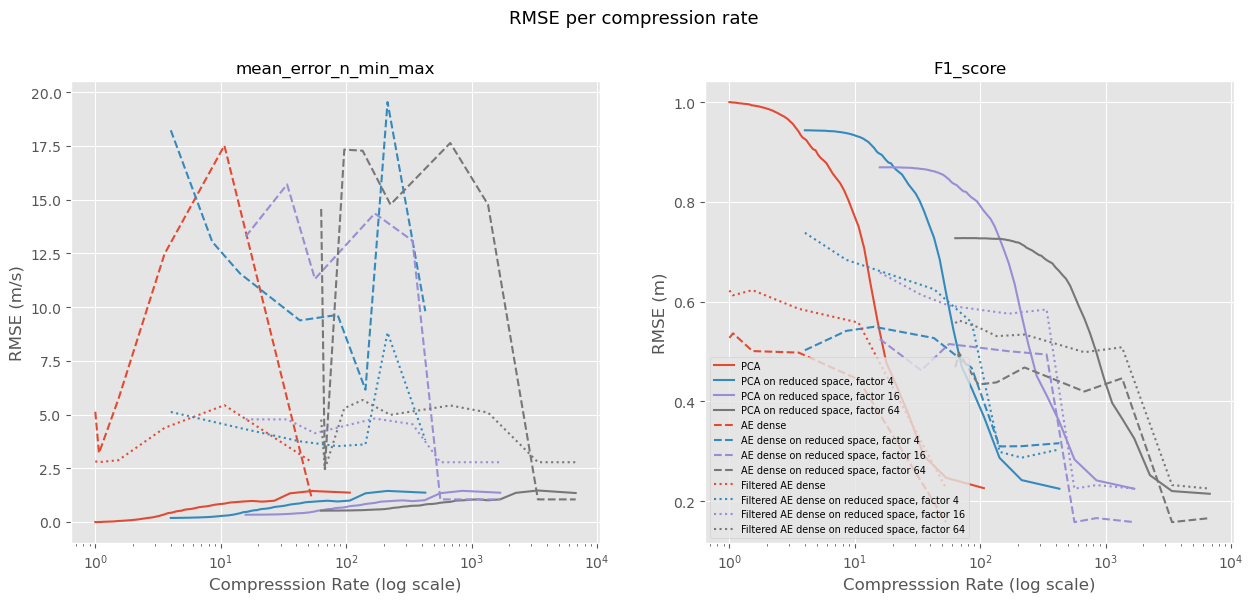

In [95]:
F1_score_max = False

# colors = ['navy', 'orchid', 'coral',
#           'tomato','olive', 'mediumseagreen',
#           'mediumblue','yellowgreen', 'deepskyblue',
#             'orange', 'dodgerblue', 'royalblue' ]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig,axs = plt.subplots(1,2,figsize=(15,6))

i=0

for n in pca_layer:
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["mean_error_n_min_max"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["F1_score"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0

layer_cr_sorted_ae_rmse_dict = sorted(cr_sorted_ae_rmse_dict["mean_error_n_min_max"].keys())


for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
    if n == 0:
        label = "AE dense"
    else:
        label = f"AE dense on reduced space, factor {4**n}"
    
    
    if len(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0]) == 1:
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        

    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0],cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], c = colors[i], ls='--', label = label)
        
        axs[1].plot(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i],ls='--', label = label)

        i=i+1
        

i=0


if filtering:

    for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
        if n == 0:
            label = "Filtered AE dense"
        else:
            label = f"Filtered AE dense on reduced space, factor {4**n}"
        
        
        if len(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0]) == 1:
            
            axs[0].scatter(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[0].hlines(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[1].hlines(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
            axs[1].vlines(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')    
            
            i=i+1    
            

        
        else:

            axs[0].plot(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0],filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], c = colors[i], ls=':', label = label)
            
            axs[1].plot(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i],ls=':', label = label)

            i=i+1


                




axs[0].set_title("mean_error_n_min_max", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    



axs[0].set_ylabel("RMSE (m/s)")  
axs[1].set_ylabel("RMSE (m)")  
axs[1].set_title("F1_score",fontsize = 12)  
fig_title = f"RMSE per compression rate"


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 7
elif len(labels) > 5:
    legend_fontsize = 8
else:
    legend_fontsize = 10

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:

    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [82]:
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(min_max_idx_truth.flatten(), min_max_idx_ae.flatten())

# fig, ax = plt.subplots(figsize=(10, 8))
# cax = ax.matshow(cm, cmap=plt.cm.Blues)
# fig.colorbar(cax)

# for (i, j), val in np.ndenumerate(cm):
#     ax.text(j, i, f'{val}', ha='center', va='center', color='red')

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Local Min/Max Detection')
# plt.show()